In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [2]:
def normalize_audio(wav):
    # 標準化音頻信號
    factor = np.max(np.abs(wav))
    if factor == 0:
        return wav
    return wav / factor

def hamming_window(wav):
    # 應用漢明窗以減少邊緣效應
    return wav * np.hamming(len(wav))

def convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels):
    audio = normalize_audio(audio)
    audio = hamming_window(audio)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sample_rate, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [3]:
target_sample_rate = 44100
# 指定 STFT 參數
hop_length = 64
n_mels = 128
n_fft = 256


In [4]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            target_sample_rate = sr
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [5]:
# 讀取分割後的音訊片段
normal_segments = load_segmented_files('output')
# 打亂 mel_spectrograms_normal 列表
np.random.shuffle(normal_segments)

100%|██████████| 3330/3330 [00:02<00:00, 1367.37it/s]


In [6]:
mel_spectrograms_normal = [convert_to_mel_spectrogram(audio[0], n_fft, hop_length, n_mels) for audio in tqdm(normal_segments)]

  0%|          | 0/3330 [00:00<?, ?it/s]C:\Users\snick\miniconda3\envs\wind_turbine\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
100%|██████████| 3330/3330 [00:23<00:00, 144.24it/s]


In [7]:
def plot_mel_spectrogram(mel_spectrogram, filename:str = None):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram of {filename}')
    plt.savefig(f'{filename}_mel_spectrogram.png')
    plt.show()

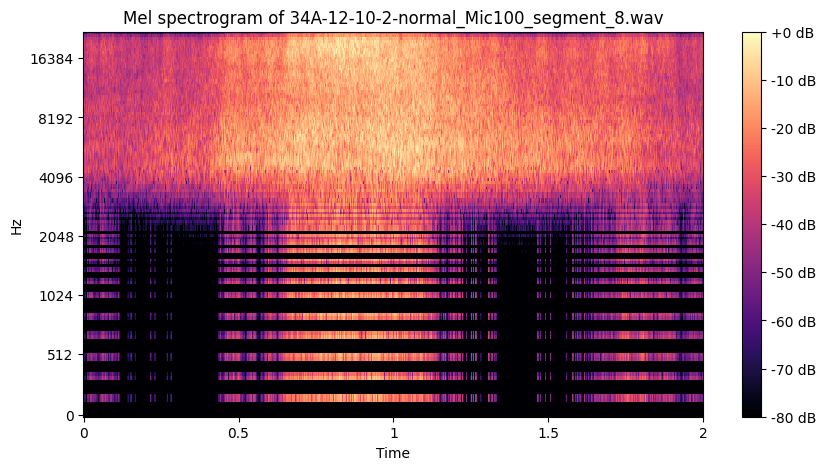

In [8]:
plot_mel_spectrogram(mel_spectrograms_normal[0], f'{normal_segments[0][1]}')

# Spilt Dataset to training and testing

In [9]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms_normal)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (2131, 128, 1379)
驗證集數據形狀: (533, 128, 1379)
測試集數據形狀: (666, 128, 1379)


# 調整數據的形狀

In [10]:
# 調整數據的形狀
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 打印轉換後的數據形狀
print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (2131, 128, 1379, 1)
驗證集數據形狀: (533, 128, 1379, 1)
測試集數據形狀: (666, 128, 1379, 1)


# 創建 CNN Autoencoder 模型

In [11]:
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def create_cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    input_height = input_shape[1]
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = Lambda(lambda x: x[:, :, :input_height, :])(decoded)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder



# 初始化模型

In [12]:
# 指定輸入形狀
input_shape = np.shape(train_data)[1:]

# 創建 CNN Autoencoder 模型
autoencoder = create_cnn_autoencoder(input_shape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1379, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 1379, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 690, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 690, 8)        1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 345, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 345, 8)        584   

In [13]:
def plot_model(autoencoder):
    from tensorflow.keras.utils import plot_model
    plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
    
plot_model(autoencoder)

In [14]:
from tensorflow.keras.optimizers import Adam 
# 設定初始學習率
initial_learning_rate = 0.001

# 創建 Adam 優化器並指定學習率
optimizer = Adam(learning_rate=initial_learning_rate)

# 編譯模型
autoencoder.compile(optimizer='adam', loss='mse')

# 訓練模型

In [15]:
history = autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(test_data, test_data),
                verbose=2)

Epoch 1/100
134/134 - 13s - loss: 0.0391 - val_loss: 0.0163 - 13s/epoch - 100ms/step
Epoch 2/100
134/134 - 7s - loss: 0.0144 - val_loss: 0.0122 - 7s/epoch - 54ms/step
Epoch 3/100
134/134 - 7s - loss: 0.0095 - val_loss: 0.0084 - 7s/epoch - 54ms/step
Epoch 4/100
134/134 - 7s - loss: 0.0077 - val_loss: 0.0073 - 7s/epoch - 54ms/step
Epoch 5/100
134/134 - 7s - loss: 0.0069 - val_loss: 0.0068 - 7s/epoch - 55ms/step
Epoch 6/100
134/134 - 7s - loss: 0.0065 - val_loss: 0.0067 - 7s/epoch - 54ms/step
Epoch 7/100
134/134 - 7s - loss: 0.0060 - val_loss: 0.0057 - 7s/epoch - 54ms/step
Epoch 8/100
134/134 - 7s - loss: 0.0053 - val_loss: 0.0045 - 7s/epoch - 54ms/step
Epoch 9/100
134/134 - 7s - loss: 0.0043 - val_loss: 0.0039 - 7s/epoch - 54ms/step
Epoch 10/100
134/134 - 7s - loss: 0.0037 - val_loss: 0.0036 - 7s/epoch - 54ms/step
Epoch 11/100
134/134 - 7s - loss: 0.0036 - val_loss: 0.0035 - 7s/epoch - 54ms/step
Epoch 12/100
134/134 - 7s - loss: 0.0037 - val_loss: 0.0034 - 7s/epoch - 54ms/step
Epoch 13/1

# 評估模型

In [16]:
test_loss = autoencoder.evaluate(val_data, val_data)
print("Test loss:", test_loss)

17/17 [==============================] - 1s 26ms/step - loss: 0.0023
Test loss: 0.002327520167455077


# 繪製訓練過程

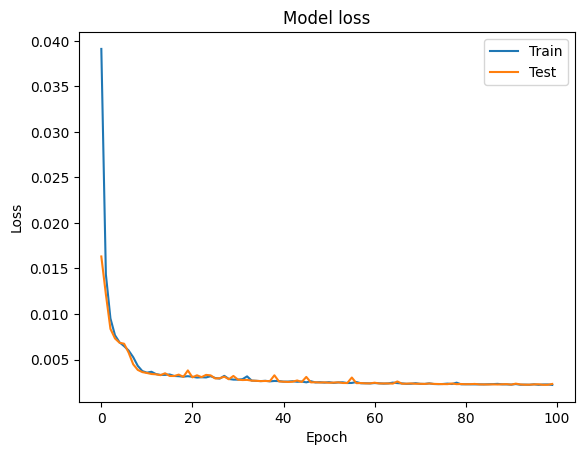

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

# 儲存模型

In [18]:
autoencoder.save('mel_autoencoder.h5')

# 使用測試集數據進行預測

In [19]:
reconstructed_data = autoencoder.predict(test_data)

21/21 [==============================] - 1s 23ms/step


In [23]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, output_name='comparison', save_only=False):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_name}.png')
        plt.close()
    else:
        plt.show()

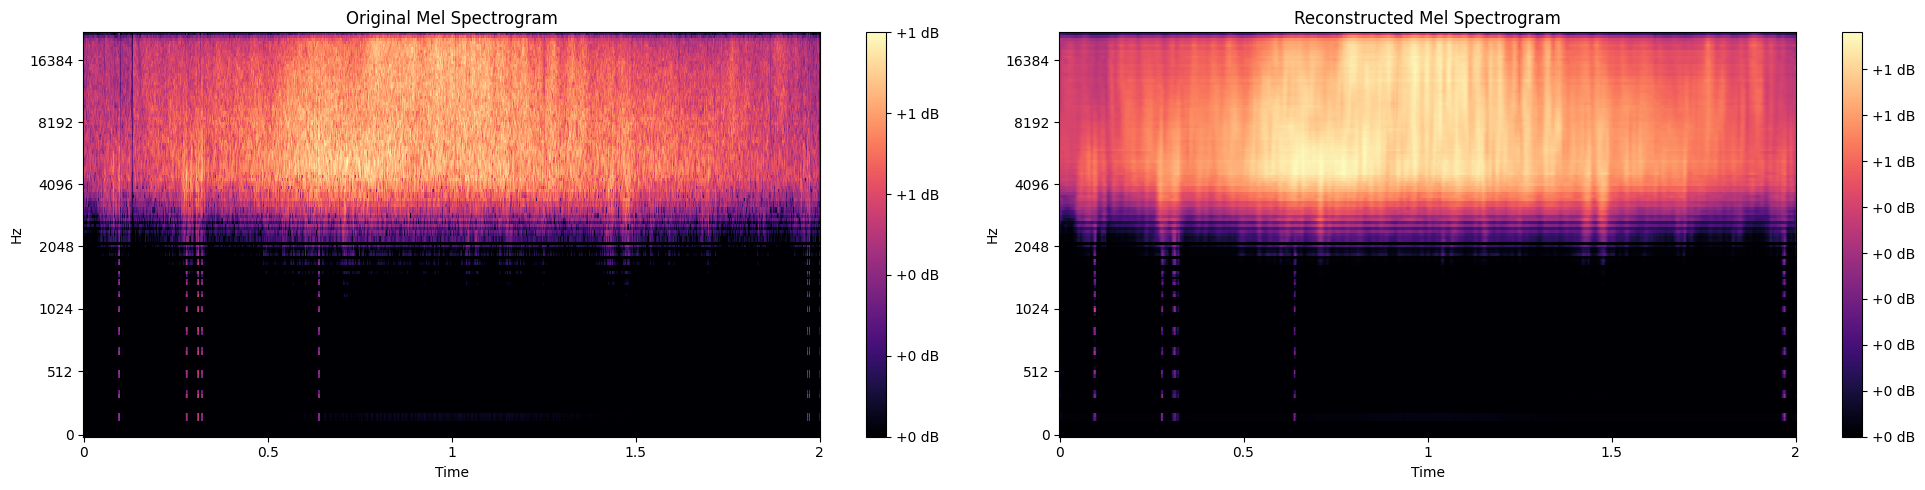

In [21]:
test_index = 300
plot_comparison(test_data[test_index].reshape(test_data[test_index].shape[0], test_data[test_index].shape[1]),
                reconstructed_data[test_index].reshape(reconstructed_data[test_index].shape[0], reconstructed_data[test_index].shape[1]),
                'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', output_name=f'{normal_segments[len(train_data) + len(val_data) + test_index][1]}')

In [26]:
for i in tqdm(range(0, len(test_data))):
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_data[i].reshape(reconstructed_data[i].shape[0], reconstructed_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', output_name=f'images/reconstruct/{normal_segments[len(train_data) + len(val_data) + i][1]}', save_only=True)

100%|██████████| 666/666 [05:14<00:00,  2.12it/s]


計算評估指標

In [27]:
# 計算均方誤差 (MSE)
mse = np.mean((test_data - reconstructed_data) ** 2)
print("Reconstruction MSE:", mse)

# 計算平均絕對誤差 (MAE)
mae = np.mean(np.abs(test_data - reconstructed_data))
print("Reconstruction MAE:", mae)

# 計算均方根誤差 (RMSE)
rmse = np.sqrt(np.mean((test_data - reconstructed_data) ** 2))
print("Reconstruction RMSE:", rmse)

Reconstruction MSE: 0.002314064036311143
Reconstruction MAE: 0.029576146591791693
Reconstruction RMSE: 0.04810471948064081
